In [26]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

from sklearn.feature_selection import SelectKBest
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

from model import TPALSTM
from other_models import LSTM
import pandas as pd
from dataset import ElectricityDataModule
from util import RSE, CORR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data_df = np.load('data/kbest_dataset.npy')
num_features = data_df.shape[1]

In [6]:
def choose_features(best_f_idx, worst_f_idx):
    data = np.load('data/dataset_norm.npy')
    X = data[:, :-1]
    y = data[:, -1]
    kbest = SelectKBest(k=worst_f_idx).fit(X, y)
    features = kbest.get_support(indices=True)[best_f_idx:]

    custom_data = np.concatenate((X[:, features], y[:, None]), axis=1)
    np.save("data/custom_dataset.npy", custom_data)
    return custom_data

custom_data = choose_features(best_f_idx=0, worst_f_idx =30)
num_features = custom_data.shape[1]

In [7]:
data_splits = {
    "train": 0.7,
    "val": 0.15,
    "predict": 0.15
}

pred_horizon = 4

elec_dm = ElectricityDataModule(
    dataset_splits=data_splits,
    batch_size=128,
    window_size=24,
    pred_horizon=pred_horizon,
    data_style="custom"
)

In [8]:
run_name = f"{pred_horizon}ts-kbest30-mlp"

In [9]:
hid_size = 64
n_layers = 1
num_filters = 3

**LSTM**

In [17]:
wandb_logger_stacked_lstm = WandbLogger(
    name=f'{run_name}-Stacked-LSTM-{hid_size}-{n_layers}l',
    save_dir='logs',
    project='Time-Series project',
    log_model=True
)

checkpoint_loss_stacked_lstm = ModelCheckpoint(
    dirpath=f"checkpoints/{run_name}/Stacked-LSTM",
    filename='BEST-{epoch}-{val_loss:.3f}-{val_score:.3f}',
    save_top_k=1,
    monitor="val/loss",
    mode="min"
)

stacked_lstm_trainer = pl.Trainer(
    max_epochs=80,
    accelerator='gpu',
    callbacks=[checkpoint_loss_stacked_lstm],
    strategy='auto',
    devices=1,
    logger=wandb_logger_stacked_lstm
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
stacked_lstm = LSTM(
    input_size=num_features,
    lstm_hid_size=hid_size,
    linear_hid_size=100,
    output_horizon=pred_horizon,
    n_layers=n_layers
)

In [19]:
stacked_lstm_trainer.fit(stacked_lstm, elec_dm)
wandb_logger_stacked_lstm.experiment.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type       | Params
-----------------------------------------
0 | lstm      | LSTM       | 214 K 
1 | linear    | Sequential | 13.3 K
2 | criterion | MSELoss    | 0     
-----------------------------------------
227 K     Trainable params
0         Non-trainable params
227 K     Total params
0.911     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

F:\TPA-LSTM\TS_project\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
F:\TPA-LSTM\TS_project\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
elec_dm.setup("predict")

model_path = "checkpoints/4ts-kbest/Stacked-LSTM/BEST-epoch=73-val_loss=0.000-val_score=0.000.ckpt"
stacked_lstm = LSTM.load_from_checkpoint(model_path)

pred_dl = elec_dm.predict_dataloader()

y_pred = stacked_lstm_trainer.predict(stacked_lstm, pred_dl)

In [ ]:
batch_idx = 0
for i, batch in enumerate(pred_dl):
    inputs, labels = batch
    X, ytrue = inputs[batch_idx][:, -1], labels[batch_idx].squeeze()
    ypred = y_pred[i][batch_idx].squeeze()
    
    X = X.cpu().numpy()
    ytrue = ytrue.cpu().numpy()
    ypred = ypred.cpu().numpy()
    # print(inputs.shape)
    # print(labels.shape, y_pred[i].shape)

    plt.figure(figsize=(15, 5))
    plt.plot(range(0, 24), X, label="Input")
    plt.scatter(range(24, 24 + pred_horizon), ytrue, color='red', label="True price")
    plt.scatter(range(24, 24 + pred_horizon), ypred, color='green', label="Predicted price")
    plt.legend()
    plt.title("Stacked-LSTM")
    plt.show()

    if i == 3:
        break

**TPA-LSTM**

In [7]:
# name = f'{run_name}-TPA-LSTM-{hid_size}-{num_filters}f-{n_layers}l'
name = f'{run_name}-TPA-LSTM'

wandb_logger_tpalstm = WandbLogger(
    name=name,
    save_dir='logs',
    project='Time-Series project',
    log_model=True
)

checkpoint_loss_tpalstm = ModelCheckpoint(
    dirpath=f"checkpoints/{run_name}/TPA-LSTM",
    filename=name,
    save_top_k=1,
    monitor="val/loss",
    mode="min"
)

tpalstm_trainer = pl.Trainer(
    max_epochs=60,
    # accelerator='gpu',
    callbacks=[checkpoint_loss_tpalstm],
    strategy='auto',
    devices=1,
    logger=wandb_logger_tpalstm
)

wandb: Currently logged in as: fraikinarchie (mva-data-challenge). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
tpa_lstm = TPALSTM(
    input_size=num_features,
    hidden_size=hid_size,
    output_horizon=pred_horizon,
    num_filters=num_filters,
    obs_len=24,
    n_layers=n_layers,
    lr=1e-3
)

In [9]:
tpalstm_trainer.fit(tpa_lstm, elec_dm)
wandb_logger_tpalstm.experiment.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type                     | Params
-------------------------------------------------------
0 | hidden    | Linear                   | 768   
1 | relu      | ReLU                     | 0     
2 | lstm      | LSTM                     | 24.8 K
3 | attention | TemporalPatternAttention | 4.6 K 
4 | mlp_out   | Sequential               | 2.2 K 
5 | linear    | Linear                   | 260   
6 | criterion | MSELoss                  | 0     
-------------------------------------------------------
32.7 K    Trainable params
0         Non-trainable params
32.7 K    Total params
0.131     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

F:\TPA-LSTM\TS_project\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
F:\TPA-LSTM\TS_project\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/corr,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
train/loss,█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/rse,█▆▅▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val/corr,▁▂▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
val/loss,██▇▇▆▆▇▆▆▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/rse,▇█▇▇▆▇█▇▇███▇▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▂▁▂▁▁▁▁▁▂▁▁▂
epoch,59
train/corr,0.86452
train/loss,0.00219


In [ ]:
elec_dm.setup("predict")

model_path = f"checkpoints/{run_name}/TPA-LSTM/BEST-epoch=35-val_loss=0.000-val_score=0.000.ckpt"
tpa_lstm = TPALSTM.load_from_checkpoint(model_path)

pred_dl = elec_dm.predict_dataloader()

y_pred = tpalstm_trainer.predict(tpa_lstm, pred_dl)

In [ ]:
batch_idx = 0
for i, batch in enumerate(pred_dl):
    inputs, labels = batch
    X, ytrue = inputs[batch_idx][:, -1], labels[batch_idx].squeeze()
    ypred = y_pred[i][batch_idx].squeeze()
    
    X = X.cpu().numpy()
    ytrue = ytrue.cpu().numpy()
    ypred = ypred.cpu().numpy()
    # print(inputs.shape)
    # print(labels.shape, y_pred[i].shape)

    plt.figure(figsize=(15, 5))
    plt.plot(range(0, 24), X, label="Input")
    plt.scatter(range(24, 24 + pred_horizon), ytrue, color='red', label="True price")
    plt.scatter(range(24, 24 + pred_horizon), ypred, color='green', label="Predicted price")
    plt.legend()
    plt.title("TPA-LSTM")
    plt.show()

    if i == 3:
        break

**VAR**

In [19]:
means = custom_data.mean(axis=0)
stds = custom_data.std(axis=0)

normed_data = (custom_data - means) / stds

In [20]:
train_lim = math.floor(data_splits['train'] * custom_data.shape[0]) 
test_lim =  math.floor(data_splits['val'] * custom_data.shape[0]) + train_lim

train_data = normed_data[:train_lim]
test_data = normed_data[test_lim:]

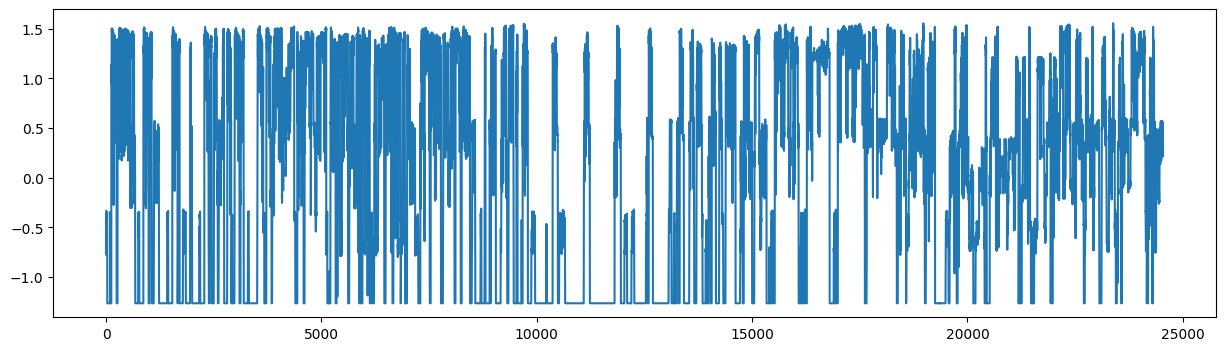

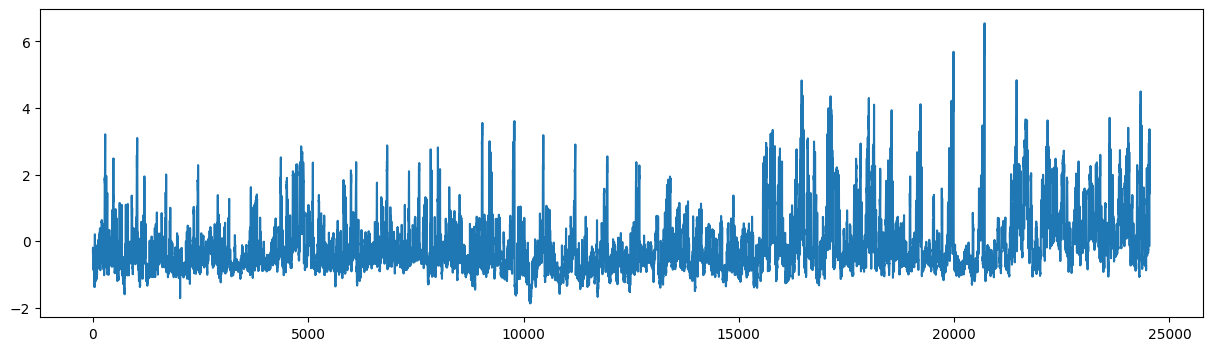

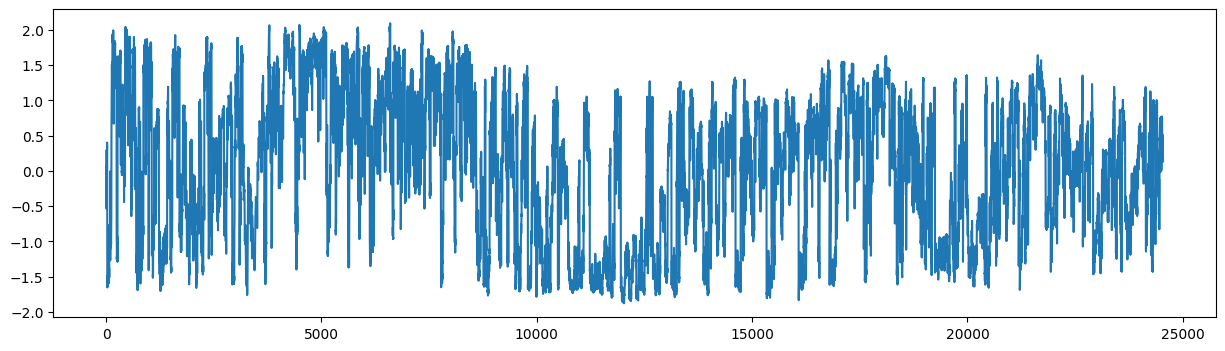

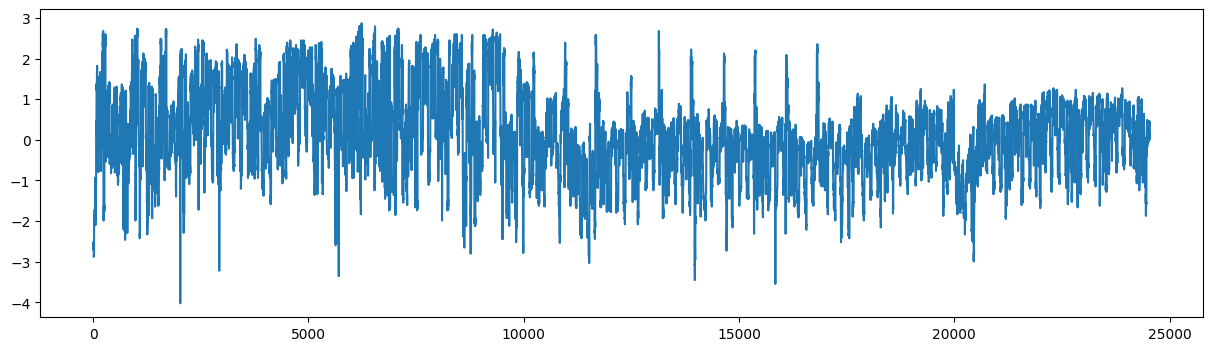

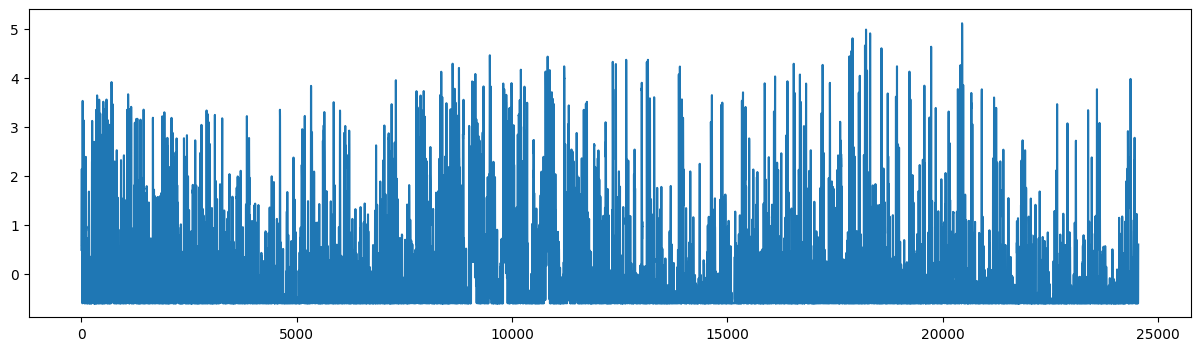

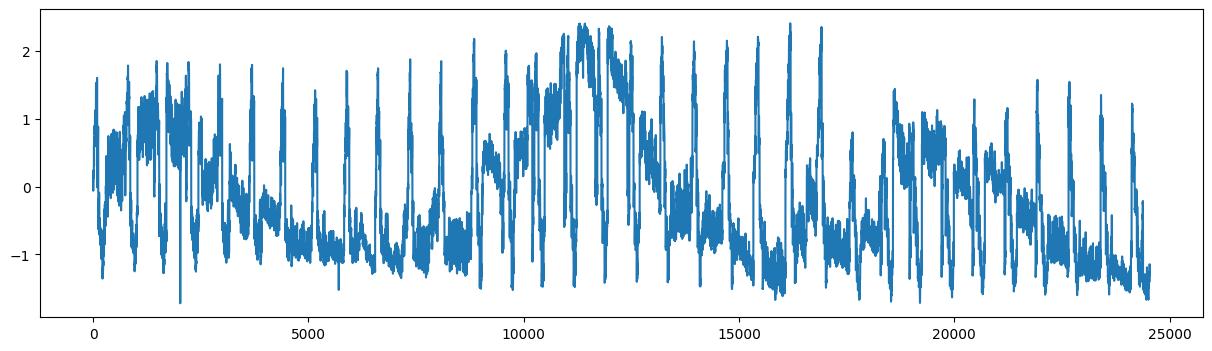

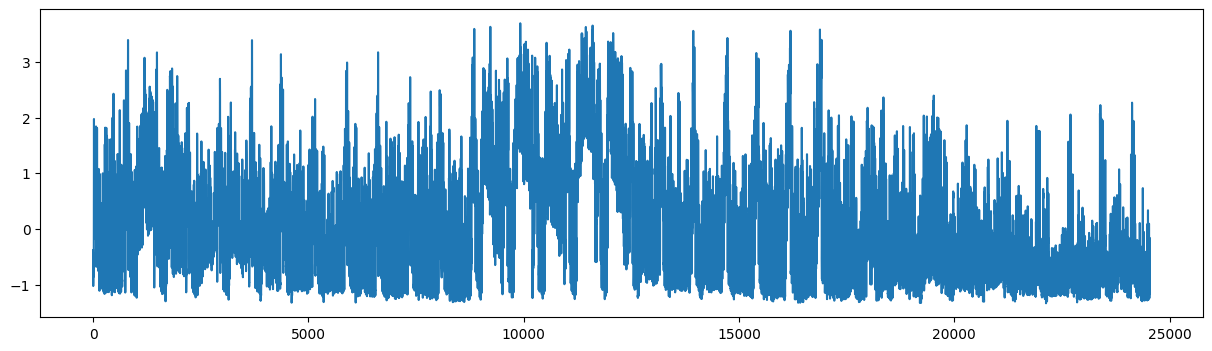

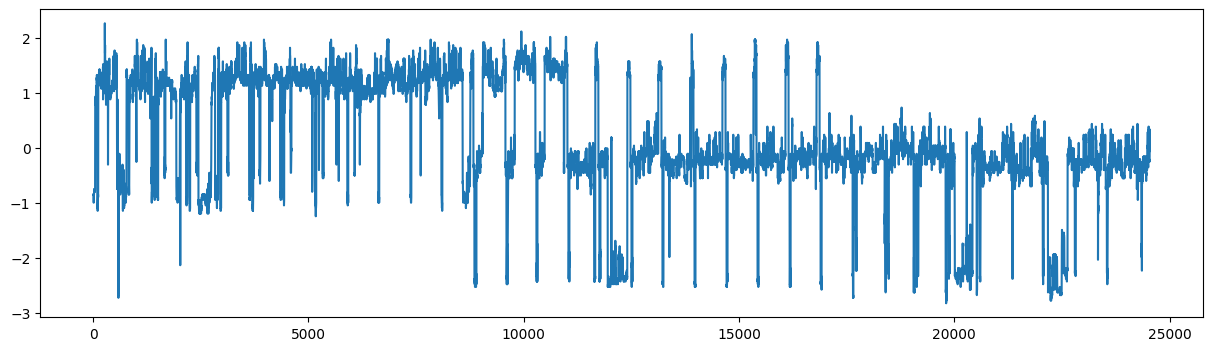

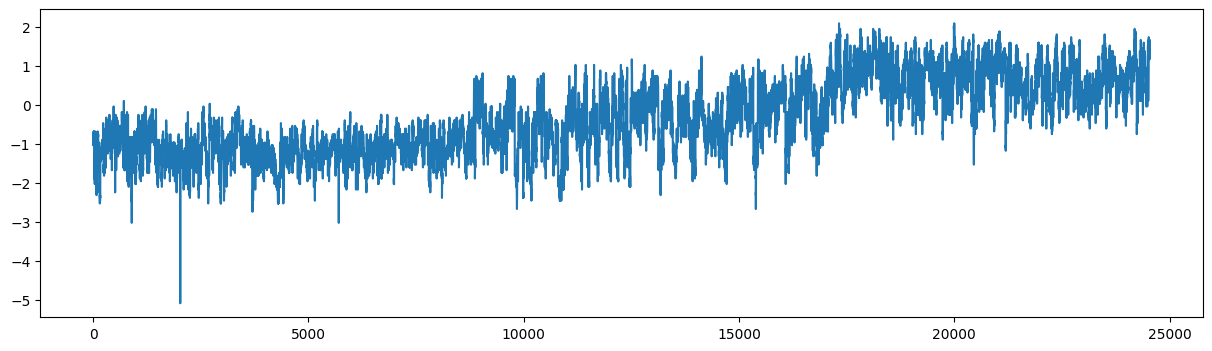

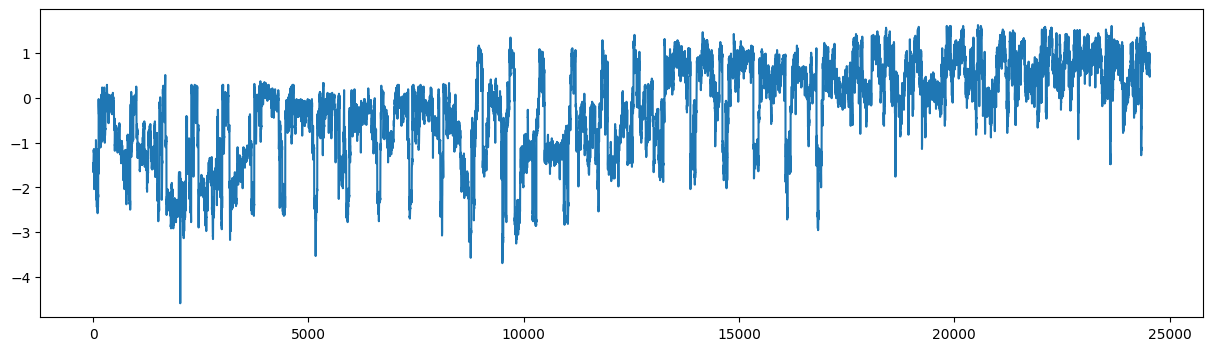

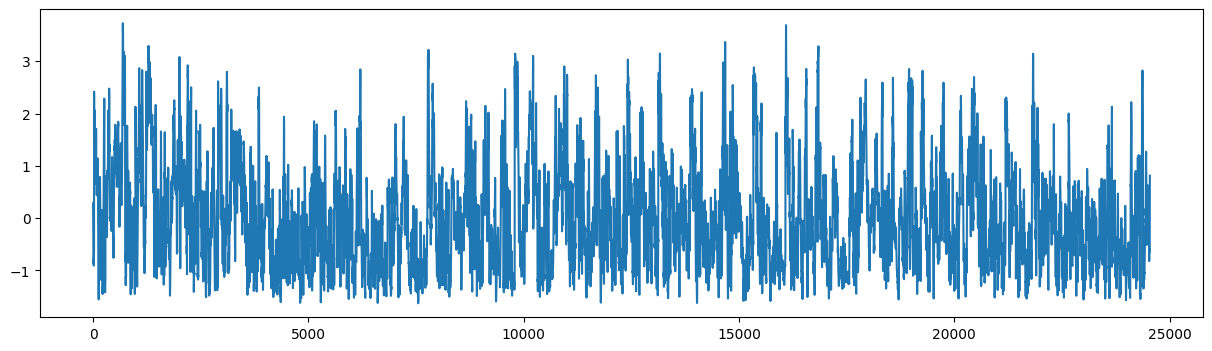

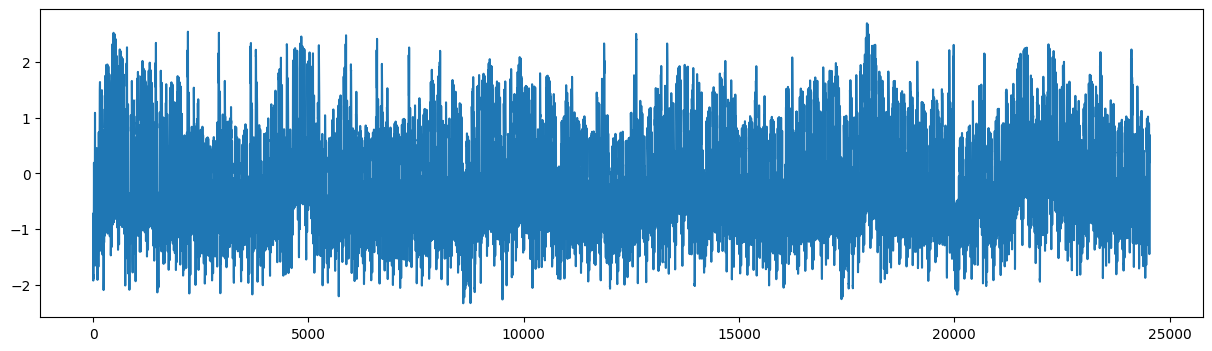

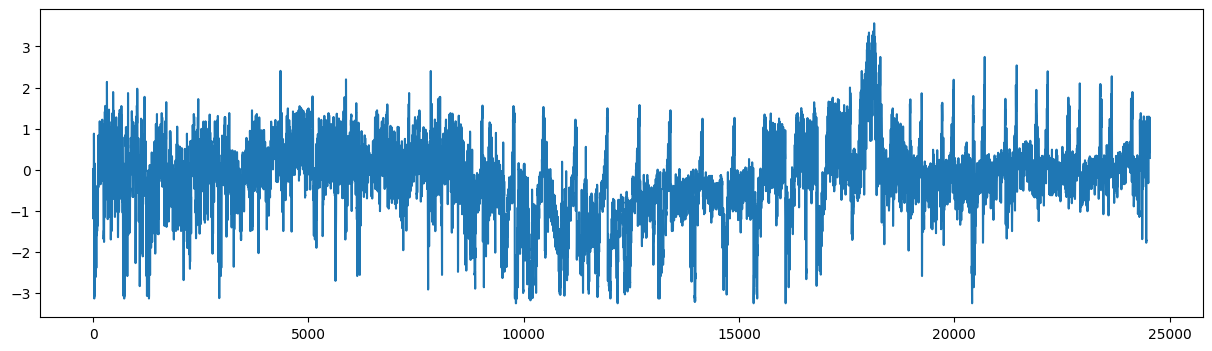

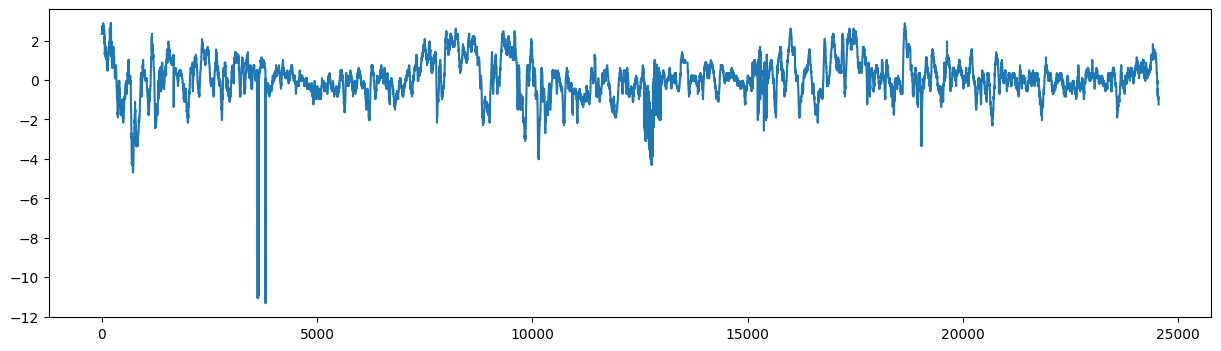

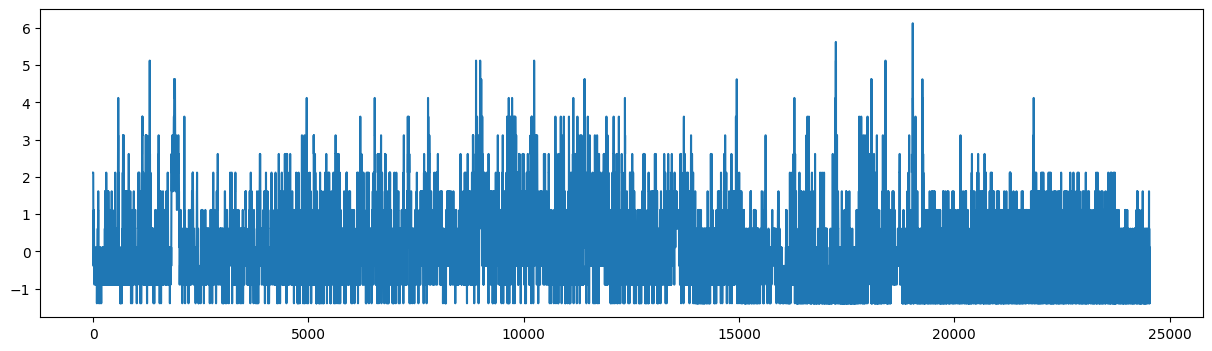

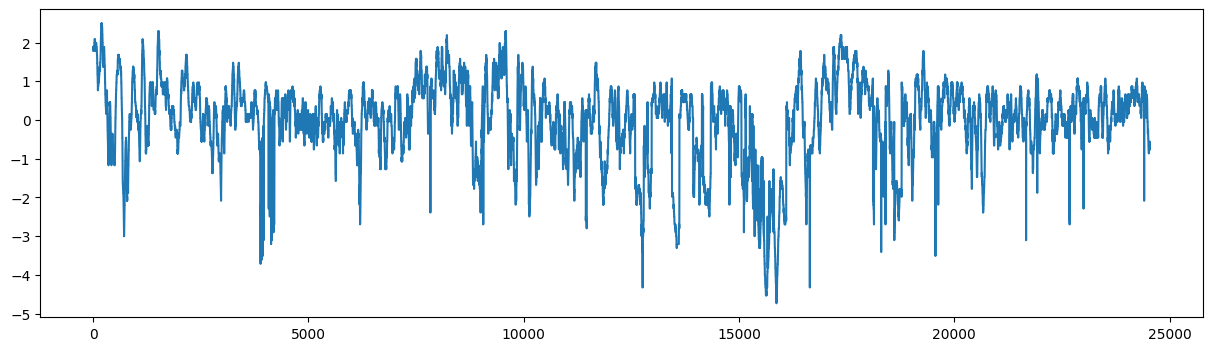

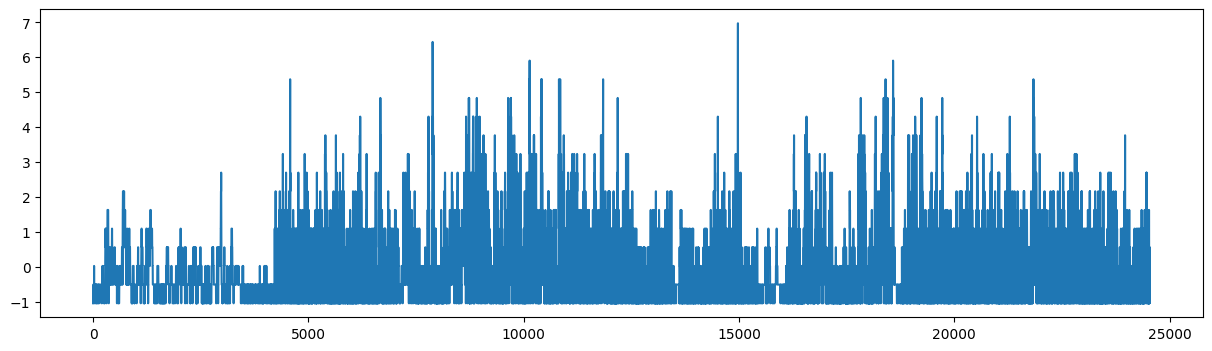

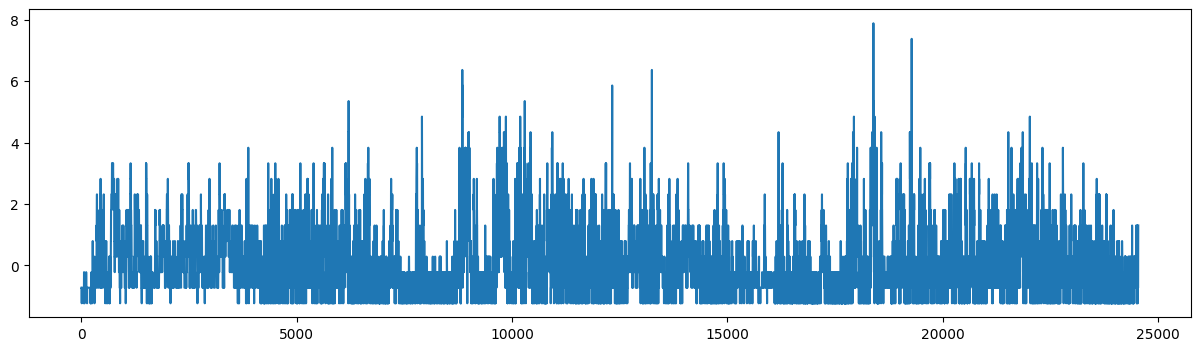

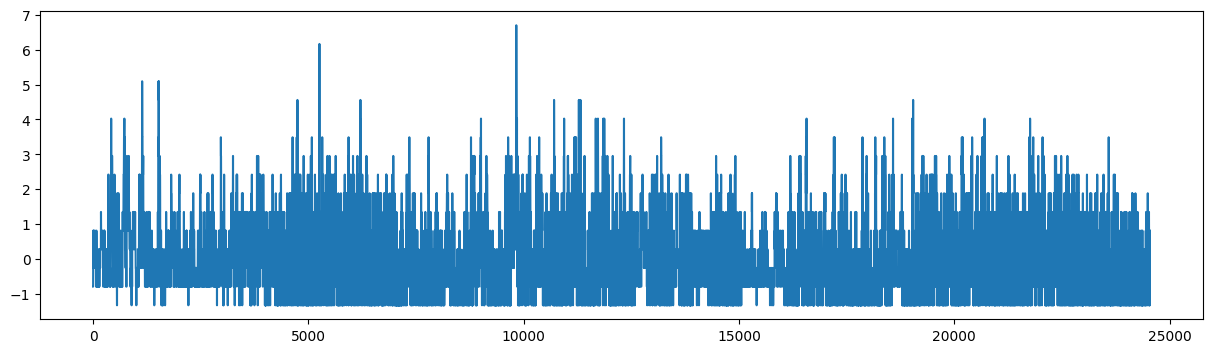

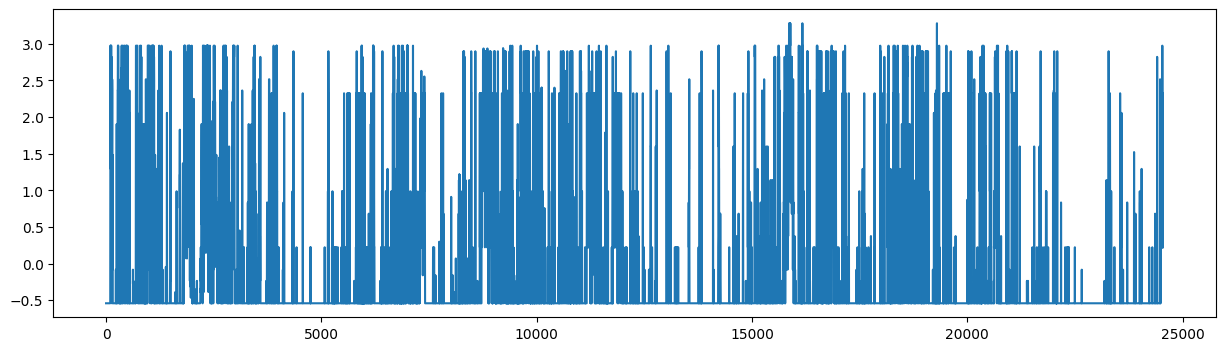

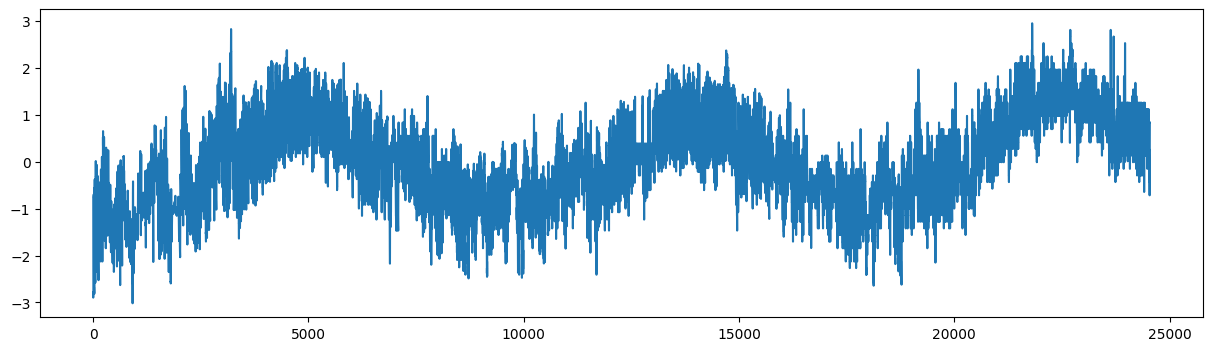

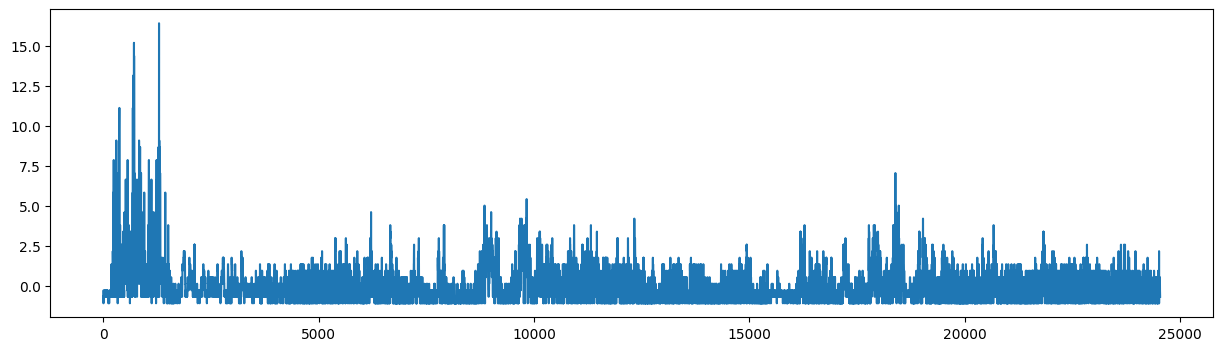

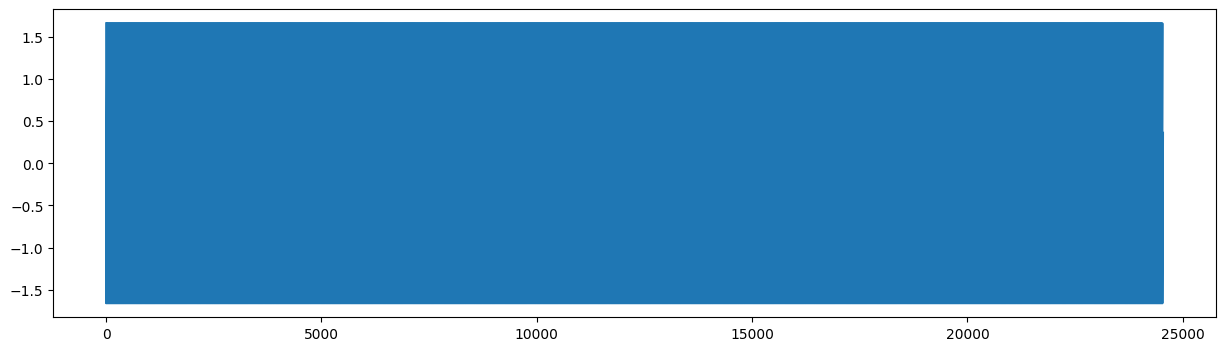

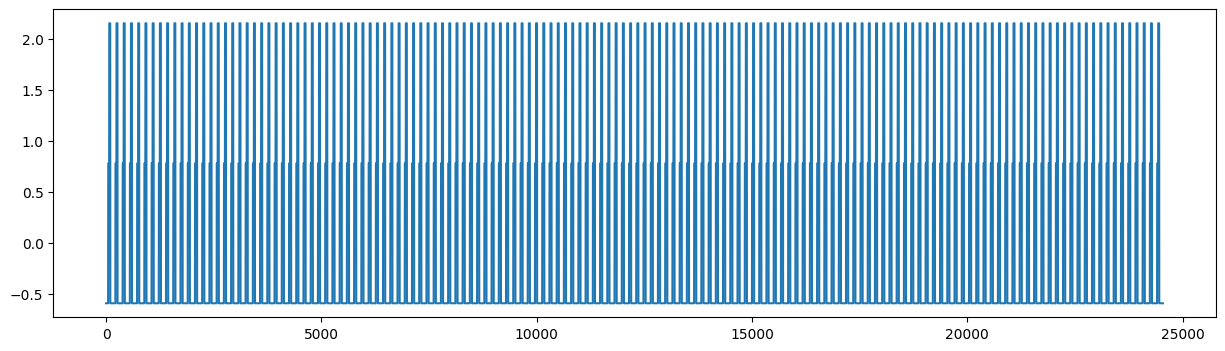

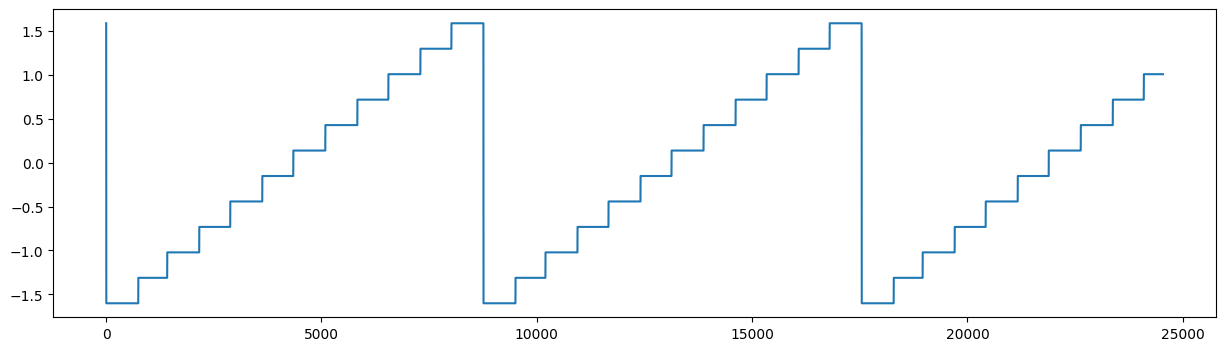

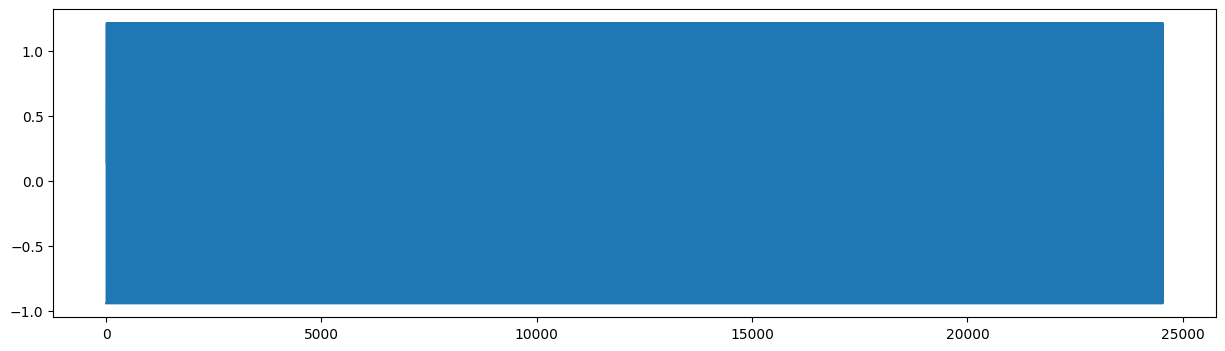

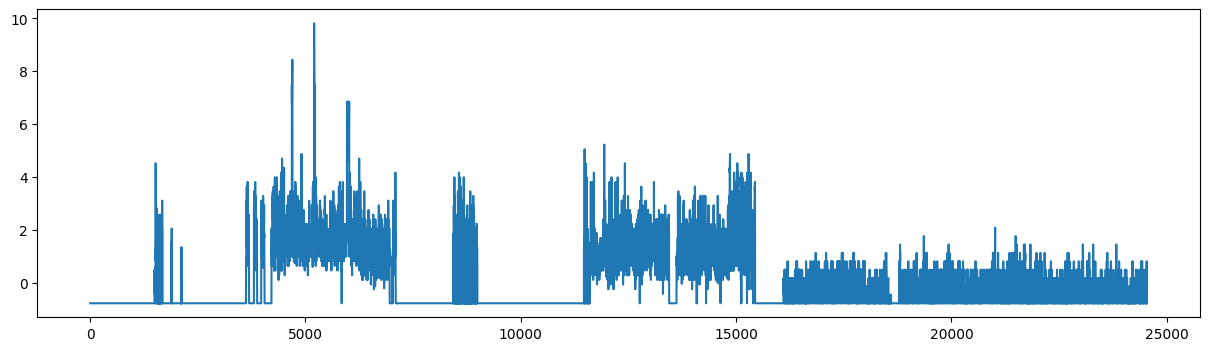

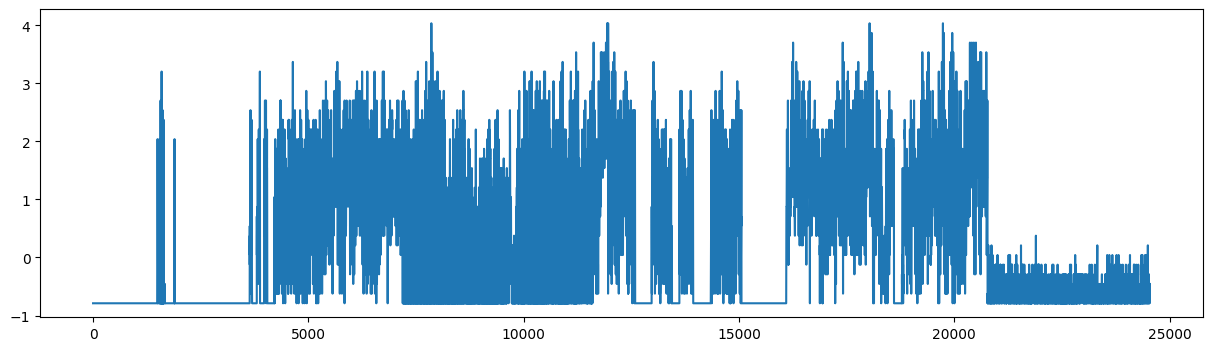

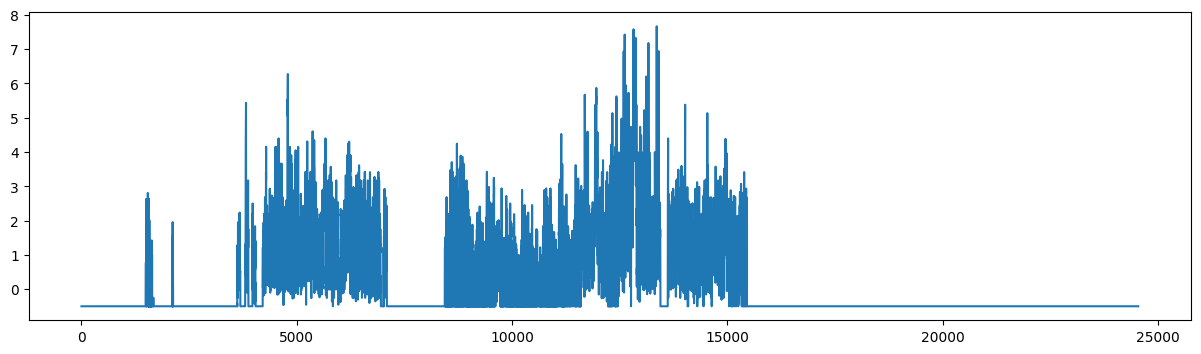

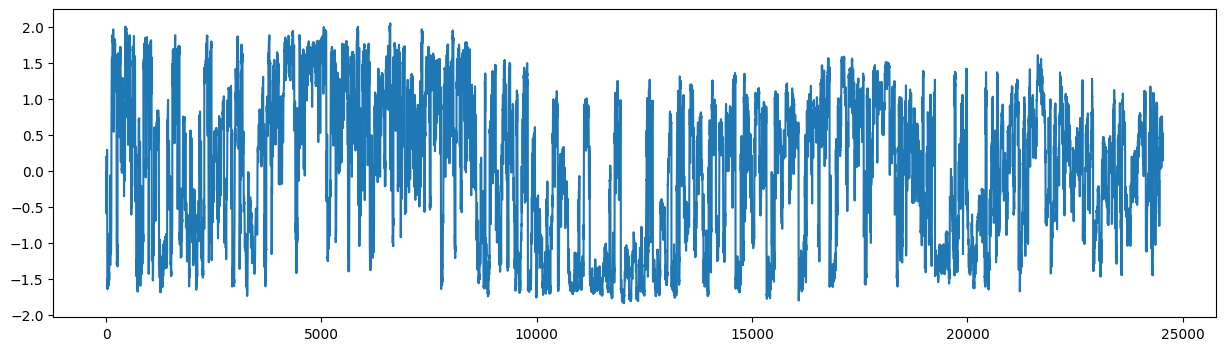

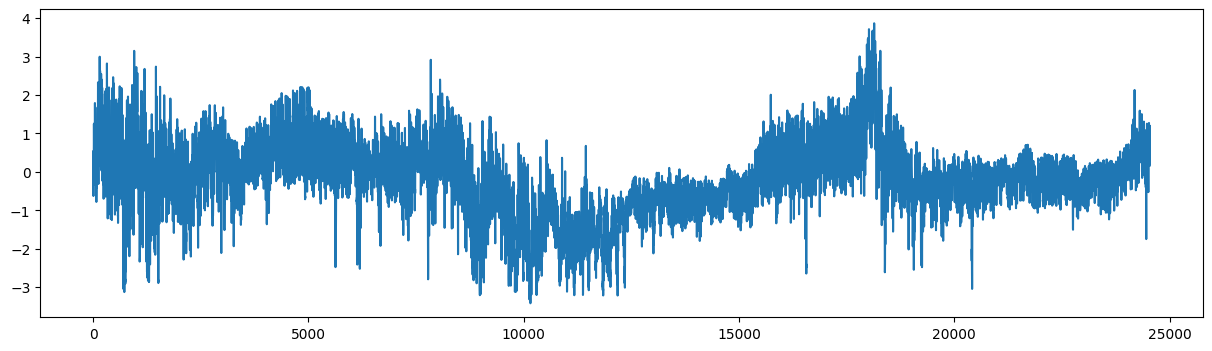

In [21]:
for i in range(train_data.shape[1]):
    plt.figure(figsize=(15, 4))
    plt.plot(train_data[:, i])
    plt.show()

In [25]:
var_model = VAR(train_data)
var_res = var_model.fit(24)


(4, 31)

In [29]:
n = test_data.shape[0] - (24 + pred_horizon)
ypreds = np.zeros((n, pred_horizon))
ytrue = np.zeros((n, pred_horizon))

for i in range(n):
    ypreds[i] = var_res.forecast(test_data[i: i +24], 4)[:, -1]
    ytrue[i] = test_data[i + 24: i + 24 + pred_horizon, -1]
    
var_rse = RSE(ypreds, ytrue)
var_corr = CORR(ypreds, ytrue)
print(f"VAR predictions - RSE: {var_rse}, CORR: {var_corr}")

VAR predictions - RSE: 14157201916.416891, CORR: -0.05270253849942937
